In [ ]:
#model
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimz
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class CnnModel(nn.Module):
  def __init__(self, num_classes=10):
      super().__init__()

      self.conv = nn.Sequential(
          nn.Conv2d(3,32,3,2,1),
          nn.InstanceNorm2d(32, affine=True),
          nn.LeakyReLU(0.2), #output -> 32*16*16

          nn.Conv2d(32,64,3,2,1),
          nn.InstanceNorm2d(64, affine=True),
          nn.LeakyReLU(0.2), #output -> 64*8*8

          nn.Conv2d(64,128,3,2,1),
          nn.InstanceNorm2d(128, affine=True),
          nn.LeakyReLU(0.2), #output -> 128*4*4
      )

      self.fc = nn.Sequential(
          nn.Linear(2048,512),
          nn.ReLU(),
          nn.Dropout(0.25),

          nn.Linear(512,512),
          nn.ReLU(),
          nn.Dropout(0.25),

          nn.Linear(512,num_classes),
      )

  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)

    return x

model = CnnModel(num_classes=len(test_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train(model, train_loader,val_loader, criterion, optimizer, epochs= 20):

    model.train()
    for epoch in range(epochs):

        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {100*train_correct/train_total:.2f}% | "
              f"Val Acc: {100*val_correct/val_total:.2f}%")

cuda


In [ ]:
#training

from pathlib import Path

TRAIN_EPOCHS = 20
path = Path("/content/drive/MyDrive")
WEIGHTS_PATH = path / "vgg_cifar_weights.pt"

if WEIGHTS_PATH.is_file():
    model.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights from file:", WEIGHTS_PATH)
else:
    train(model, train_loader, val_loader, criterion, optimizer, epochs=20)
    torch.save(model.state_dict(), WEIGHTS_PATH)

# Evaluate on test set
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"\nTest Accuracy: {100*test_correct/test_total:.2f}%")


Loaded weights from file: /content/drive/MyDrive/vgg_cifar_weights.pt

Test Accuracy: 70.93%


True Label: dog 5
Prediction: dog 5
Label Probabilities: tensor([3.5744e-10, 2.0480e-10, 4.9035e-06, 1.7354e-04, 3.8822e-10, 9.9982e-01,
        1.8701e-10, 1.3230e-07, 2.5658e-10, 1.0327e-09], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.9998214840888977


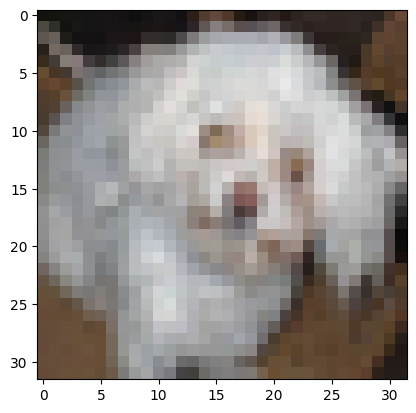

In [ ]:
CIFAR_LABELS  = test_dataset.classes

import matplotlib.pyplot as plt
import torch.nn.functional as F

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)


def tell(img, label, model, target_label=None):
    print("True Label:", CIFAR_LABELS[label], label)
    print("Prediction:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

test_img, test_label = test_dataset[1000]
test_img = test_img.to(device)
imshow(test_img)
tell(test_img, test_label, model)

Perturbation: [0.6  0.6  0.   0.   0.75]
True Label: dog 5
Prediction: dog 5
Label Probabilities: tensor([3.0681e-09, 9.5971e-10, 1.5957e-05, 2.1612e-04, 2.7500e-09, 9.9977e-01,
        1.4097e-09, 2.1387e-07, 2.0585e-09, 2.3985e-09], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.9997677206993103


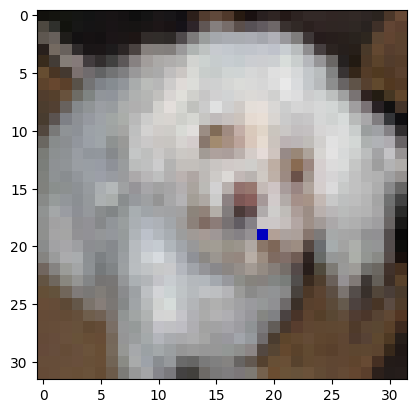

In [ ]:
def perturb(p, img):
    # Elements of p should be in range [0,1]
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb)
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img)
    print("Perturbation:", p)
    imshow(p_img)
    tell(p_img, label, model, target_label)

visualize_perturbation(np.array([0.6,0.6,0,0,0.75]), test_img, test_label, model)

Target Probability [Iteration 0]: 0.7764180302619934
Target Probability [Iteration 10]: 0.5660198926925659
Target Probability [Iteration 20]: 0.5099128484725952
Target Probability [Iteration 30]: 0.20558443665504456
Target Probability [Iteration 40]: 0.16077189147472382
Target Probability [Iteration 50]: 0.16077189147472382
Target Probability [Iteration 60]: 0.15762817859649658
Target Probability [Iteration 70]: 0.15762817859649658
Target Probability [Iteration 80]: 0.15762817859649658
Target Probability [Iteration 90]: 0.15762817859649658
Perturbation: [0.70265013 0.36778779 0.29268372 0.99921743 0.12193268 0.73690384
 0.31128626 0.23775769 0.77161874 0.01235759 0.6654611  0.23780078
 0.08450023 0.31389578 0.22296615]
True Label: dog 5
Prediction: cat 3
Label Probabilities: tensor([9.9346e-06, 1.7648e-05, 3.5165e-02, 9.2832e-01, 1.1000e-07, 3.5880e-02,
        2.6238e-07, 3.4107e-04, 3.1403e-05, 2.3848e-04], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0

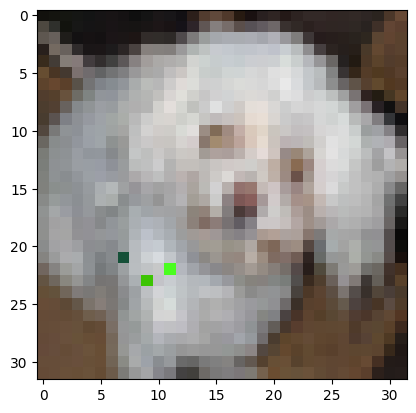

In [ ]:
def perturb(p, img):
    # p length = 15 (3 pixels * 5 values each)
    img_size = img.size(1)  # C x H x W, assume H == W
    p_img = img.clone()
    for i in range(3):
        idx = i * 5
        xy = (p[idx:idx+2].copy() * img_size).astype(int)
        xy = np.clip(xy, 0, img_size - 1)
        rgb = p[idx+2:idx+5].copy()
        rgb = np.clip(rgb, 0, 1)
        # Set pixel color (assuming img channels first, RGB channels)
        p_img[:, xy[0], xy[1]] = torch.from_numpy(rgb)
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img)
    print("Perturbation:", p)
    imshow(p_img)
    tell(p_img, label, model, target_label)

def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for xs in candidates:
            p_img = perturb(xs, img)
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F * (x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(len(x_next))[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    # Each candidate now has 15 values (3 pixels * 5)
    candidates = np.random.random((pop_size, 15))
    # For RGB channels (positions 2,3,4; 7,8,9; 12,13,14), sample from normal distribution clipped [0,1]
    for i in range(3):
        candidates[:, i*5+2:i*5+5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)

    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)

    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)

    for iteration in range(iters):
        if is_success():
            break
        if verbose and iteration % 10 == 0:
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        new_gen_candidates = evolve(candidates, strategy="resample")
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]

    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]

    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)

    return is_success(), best_solution, best_score

# Example call for untargeted attack
_ = attack(model, test_img, test_label)


In [ ]:
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
for idx in range(len(CIFAR_LABELS)):
    if idx != test_label:
        targeted_results[idx] = attack(model, test_img, test_label, target_label=idx, iters=100, verbose=False)
        print(CIFAR_LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(CIFAR_LABELS[idx], idx, "True Label")

airplane 0 False 0.00020291654800530523
automobile 1 False 8.115097443806008e-05
bird 2 True 0.6290165781974792
cat 3 True 0.5497058629989624
deer 4 False 1.3375264643400442e-05
dog 5 True Label
frog 6 False 1.5885363609413616e-05


KeyboardInterrupt: 